# Homework 3 STA365

## Question 1

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [13]:
# loc is mean and scale is standard deviation
n = 30; x = stats.norm(loc=0, scale=1).rvs(size=n)
C,G = 2,10000  # chains, Gibbs samples
theta,tau = np.zeros([C,G]),np.zeros([C,G])
theta[:,0] = 1000  # initialization
for c in range(C):
    for g in range(1, G):
        # https://en.wikipedia.org/wiki/Gamma_distribution
        
        # Update tau (Gamma full conditional)
        scale_tau = np.sum((x - theta[c - 1, g - 1])**2) / 2
        tau[c, g] = stats.gamma.rvs(a=n / 2, scale=1 / scale_tau)
        
        # Update theta (Normal full conditional)
        mean_theta = n * np.mean(x) / (tau[c, g] + n)
        var_theta = 1 / (tau[c, g] + n)
        theta[c, g] = stats.norm.rvs(loc=mean_theta, scale=np.sqrt(var_theta))

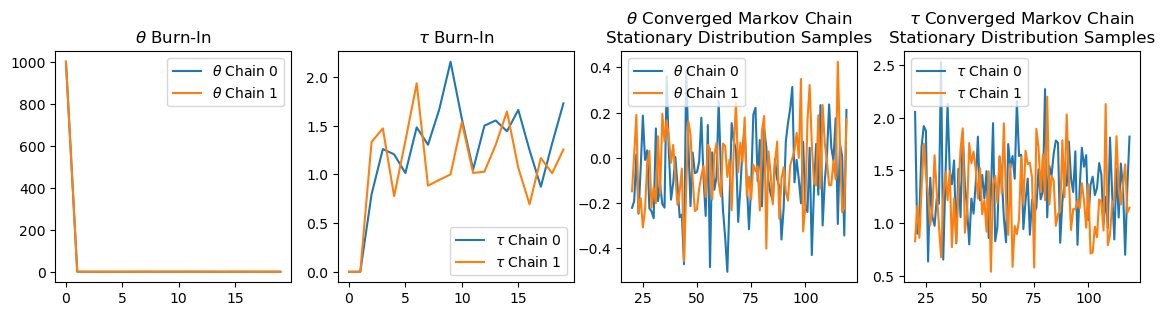

In [14]:
fig,ax = plt.subplots(1, 4, figsize=(14,3)); ax[0].set_title("$\\theta$ Burn-In"); ax[1].set_title("$\\tau$ Burn-In"); ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples"); ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")
burn = 20
demo = 120
for c in range(C):
    ax[0].plot(theta[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend();         

## Question 2

### Model Setup

- Prior for $ \theta $:
  $$
  p(\theta) \sim N(\theta_0, \tau_0)
  $$
  where $ \theta_0 $ is the prior mean and $ \tau_0 $ is the prior precision (reciprocal of variance).

- Prior for $ \tau $:
  $$
  p(\tau) \propto \tau^{\frac{\alpha}{2} - 1} e^{-\frac{\lambda}{2} \tau}
  $$
  where $ \alpha $ and $ \lambda $ are the shape and rate parameters of the Gamma distribution.

- Likelihood for $ x $:
  $$
  p(x | \theta, \tau) = \prod_{i=1}^n \sqrt{\frac{\tau}{2\pi}} e^{-\frac{\tau}{2} (x_i - \theta)^2}
  $$

### Full Conditional Distributions

Full Conditional for $ \tau $:
The posterior for $ \tau $ is given by:
$$
p(\tau | \theta, x) \propto p(x | \theta, \tau) p(\tau)
$$

Substitute the likelihood and prior:
$$
p(\tau | \theta, x) \propto \tau^{\frac{n}{2}} e^{-\frac{\tau}{2} \sum_{i=1}^n (x_i - \theta)^2} \cdot \tau^{\frac{\alpha}{2} - 1} e^{-\frac{\lambda}{2} \tau}
$$

Combine terms:
$$
p(\tau | \theta, x) \propto \tau^{\frac{n}{2} + \frac{\alpha}{2} - 1} e^{-\frac{\tau}{2} \left( \sum_{i=1}^n (x_i - \theta)^2 + \lambda \right)}
$$

This is the kernel of a Gamma distribution:
$$
\tau | \theta, x \sim \text{Gamma}\left( \frac{n}{2} + \frac{\alpha}{2}, \, \text{rate} = \frac{1}{2} \left( \sum_{i=1}^n (x_i - \theta)^2 + \lambda \right) \right)
$$

Full Conditional for $ \theta $:
The posterior for $ \theta $ is given by:
$$
p(\theta | \tau, x) \propto p(x | \theta, \tau) p(\theta)
$$

Substitute the likelihood and prior:
$$
p(\theta | \tau, x) \propto \prod_{i=1}^n e^{-\frac{\tau}{2} (x_i - \theta)^2} \cdot e^{-\frac{\tau_0}{2} (\theta - \theta_0)^2}
$$

Combine terms:
$$
p(\theta | \tau, x) \propto e^{-\frac{\tau}{2} \left( \sum_{i=1}^n (x_i^2 - 2x_i\theta + \theta^2) \right)} \cdot e^{-\frac{\tau_0}{2} \left( \theta^2 - 2\theta_0\theta + \theta_0^2 \right)}
$$

Group $ \theta $-related terms:
$$
p(\theta | \tau, x) \propto e^{-\frac{\theta^2}{2} (\tau n + \tau_0) + \theta \left( \tau \sum_{i=1}^n x_i + \tau_0 \theta_0 \right)}
$$

This is the kernel of a Normal distribution:
$$
\theta | \tau, x \sim N\left( \frac{\tau \sum_{i=1}^n x_i + \tau_0 \theta_0}{\tau n + \tau_0}, \, \frac{1}{\tau n + \tau_0} \right)
$$

### Gibbs Sampling Algorithm

1. Initialize:
   - $ \theta = \text{mean}(x) $
   - $ \tau = 1 $

2. Iterate for $ g = 1, 2, \dots, G $:
   - Sample $ \tau $ from:
     $$
     \text{Gamma}\left( \frac{n}{2} + \frac{\alpha}{2}, \, \frac{1}{2} \left( \sum_{i=1}^n (x_i - \theta)^2 + \lambda \right) \right)
     $$
   - Sample $ \theta $ from:
     $$
     N\left( \frac{\tau \sum_{i=1}^n x_i + \tau_0 \theta_0}{\tau n + \tau_0}, \, \frac{1}{\tau n + \tau_0} \right)
     $$



In [17]:
## Python Code

import numpy as np
from scipy.stats import norm, gamma

# Data and priors
n = 30
x = np.random.normal(0, 1, size=n)  # Simulated data
alpha, lambda_ = 2, 2
theta_0, tau_0 = 0, 1  # Prior parameters

# Gibbs sampling setup
C, G = 2, 1000  # Chains, Gibbs samples
theta, tau = np.zeros([C, G]), np.zeros([C, G])
theta[:, 0] = 1  # Initialization
tau[:, 0] = 1

for c in range(C):  # Loop over chains
    for g in range(1, G):  # Loop over samples
        # Update tau (Gamma full conditional)
        sum_squares = np.sum((x - theta[c, g-1])**2)
        shape_tau = n / 2 + alpha / 2
        rate_tau = 0.5 * sum_squares + lambda_ / 2
        tau[c, g] = gamma.rvs(shape_tau, scale=1 / rate_tau)

        # Update theta (Normal full conditional)
        mean_theta = (n * np.mean(x) * tau[c, g] + theta_0 * tau_0) / (n * tau[c, g] + tau_0)
        var_theta = 1 / (n * tau[c, g] + tau_0)
        theta[c, g] = norm.rvs(loc=mean_theta, scale=np.sqrt(var_theta))


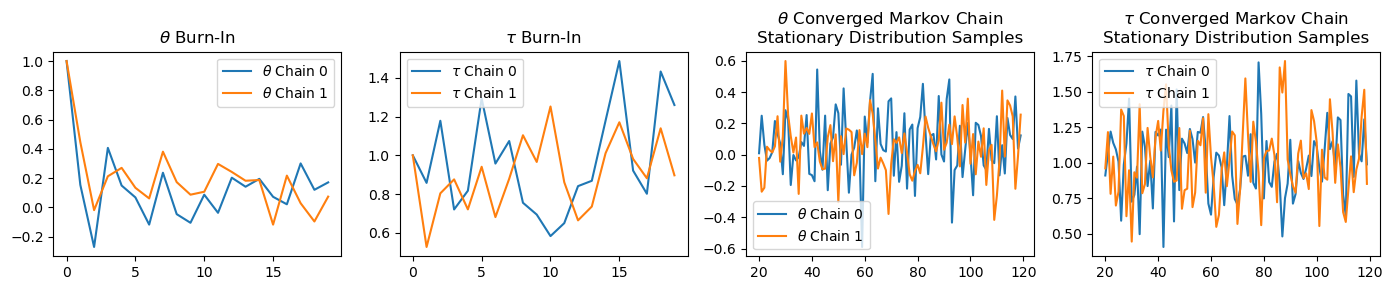

In [18]:
fig, ax = plt.subplots(1, 4, figsize=(14, 3))
ax[0].set_title("$\\theta$ Burn-In")
ax[1].set_title("$\\tau$ Burn-In")
ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples")
ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")

burn = 20  # Burn-in period
demo = 120  # Sample points to demonstrate

for c in range(C):
    ax[0].plot(theta[c, :burn], label=f"$\\theta$ Chain {c}")
    ax[1].plot(tau[c, :burn], label=f"$\\tau$ Chain {c}")
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c, burn:demo], label=f"$\\theta$ Chain {c}")
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c, burn:demo], label=f"$\\tau$ Chain {c}")

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

plt.tight_layout()
plt.show()

## Question 3

### Model Setup

1. **Prior for $ \theta $:**
   Assume $ \theta = (\theta_1, \theta_2, \dots, \theta_k) $ follows a prior:
   $$
   p(\theta) \propto \prod_{j=1}^k \theta_j^{\alpha_j - 1}
   $$
   where $ \alpha_j > 0 $ are prior hyperparameters.

2. **Likelihood:**
   Given data $ x = (x_1, x_2, \dots, x_k) $, the likelihood is:
   $$
   p(x | \theta) \propto \prod_{j=1}^k \theta_j^{x_j}
   $$

---

### Joint Distribution

The joint distribution is:
$$
p(x, \theta) = p(x | \theta) p(\theta)
$$

Substituting the prior and likelihood:
$$
p(x, \theta) \propto \prod_{j=1}^k \theta_j^{x_j} \prod_{j=1}^k \theta_j^{\alpha_j - 1}
$$

Combine the powers of $ \theta_j $:
$$
p(x, \theta) \propto \prod_{j=1}^k \theta_j^{x_j + \alpha_j - 1}
$$

---

### Posterior Distribution

The posterior distribution is proportional to the joint distribution:
$$
p(\theta | x) \propto p(x, \theta)
$$

Thus:
$$
p(\theta | x) \propto \prod_{j=1}^k \theta_j^{x_j + \alpha_j - 1}
$$

Recognizing the form of a Dirichlet distribution:
$$
\theta | x \sim \text{Dirichlet}(\alpha_1 + x_1, \alpha_2 + x_2, \dots, \alpha_k + x_k)
$$

---

### Summary

The posterior distribution of $ \theta $, given the observed data $ x $, follows a Dirichlet distribution with updated parameters:
$$
\alpha_j' = \alpha_j + x_j, \quad j = 1, 2, \dots, k
$$
